# Using a Neural Network to solve okCrushampton

As you know, okCrushampton runs on two variables:

x1 - No. of times someone goes to a coffee shop in a month

x2 - No. of times someone goes to a club in a month



In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

print(tf.__version__)


2.9.2


Pandas (or pd for short) is a great tool for processing our data before we even go anywhere near tensorlow. Usually when working with real life data, you'll find yourself spending most of your time using all of the tools that pandas has to offer before you even touch tensorflow.

In [7]:
raw_dataset = pd.read_csv('okCrushampton.csv', header=0)    #header=0 means that the first row of the file is our header

In [8]:
raw_dataset.head()

,x1_coffee,x2_club,liked
0,5,7,0
1,12,4,1
2,2,6,0
3,8,6,0
4,11,12,0


Now to split our data into data for training our Neural Network and then afterwards for testing it.

We use 80% of the raw dataset for training and 20% for testing.

What's the purpose of doing so and why do we need to do it?

We use the training to data to "fit" the model onto data for it to discover and learn the patterns of the dataset. We then use the test data to confirm that the model works on previously unseen data so that it has actually learnt the *patterns* of the data as opposed to just learning the data itself.

Usually a 80/20 split is enough!

*Note: Sometimes we use a validation set as well to tune the hyperparameters of the Neural Network model. We'll see what hyperparameters are later in this notebook*

In [9]:
train_dataset = raw_dataset.sample(frac=0.8, random_state=0)  #Picks random rows from the raw dataset
test_dataset = raw_dataset.drop(train_dataset.index)          #Drops and uses everything from the raw dataset that is in the training set


In [10]:
train_dataset.head()

,x1_coffee,x2_club,liked
208,4,3,0
188,15,2,1
12,15,4,1
221,10,8,0
239,14,7,0


Now we need to split the data along the other axis to separate features and labels.

Features are the information we always know about any sample of data. In our case, it's x1 and x2, i.e the number of times the person has gone to a coffee shop and a club in a month. 

Labels are the "goal" or "answer" to every single sample of data. In our case, it's whether we've liked them previously or not.

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#Popping the 'liked' column out of the training dataframes and putting it into the label dataframe
train_labels = train_features.pop('liked')
test_labels = test_features.pop('liked')      



In [12]:
print(train_features.head())      #There is really no need to put the print() around but it's there
                                  #for easier copy paste into a python file 


     x1_coffee  x2_club
208          4        3
188         15        2
12          15        4
221         10        8
239         14        7


In [13]:
print(train_labels.head())

208    0
188    1
12     1
221    0
239    0
Name: liked, dtype: int64


Let's see how the our data is distributed.

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]


,mean,std
x1_coffee,11.804167,4.968434
x2_club,7.333333,2.836797
liked,0.341667,0.475260


Clearly, we can see that we have a record of not liking most people on the dataset. 

Remember how we wanted to make it easier for the Neural Network by normalising our data between [0,1]?

We can easily do that with Keras. 

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


[[11.804168   7.3333335]]


Let's build a Neural Network with 2 hidden layers which have 3 neurons each. Should do the job!

In [16]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(3, activation='sigmoid'),    #Layer with 3 neurons and sigmoid activation function
      layers.Dense(3, activation='sigmoid'),    #Layer with 3 neurons and sigmoid activation function
      layers.Dense(1)                           #One last output layer which would give us a confidence rating for each sample
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))    
  #Optimisers are used to speed up/increase the quality of training by using various different algorithms.
  #Read more: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

  return model



In [17]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

#We're using a normalisation layer at the very start to normalise our data from 0-?? to 0-1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 30
Trainable params: 25
Non-trainable params: 5
_________________________________________________________________


Time to actually train our Neural Network!

```
validation_split=0.2
```
refers to us using 20% of the training dataset to tune the hyperparameters

```
epochs=400
```
An epoch means training the neural network with all the training data for one cycle. In an epoch, we use all of the data exactly once. A forward pass and a backward pass together are counted as one pass. Here we're going the entire dataset 400 times.




In [18]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,         
    verbose=0, epochs=400)


CPU times: user 10.5 s, sys: 494 ms, total: 11 s
Wall time: 11.4 s


In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [liked]')
  plt.legend()
  plt.grid(True)


We see that after around the 250th epoch, we're nearing diminishing returns. It isn't worth that much to train the data for let's say till 350 or 400 (but we do it anyway!)

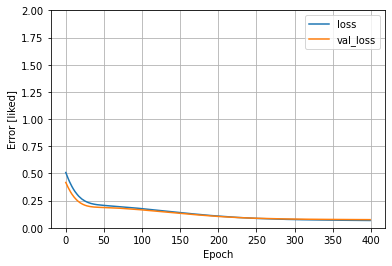

In [20]:
plot_loss(history)


In [29]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [32]:
print("Train loss: ", history.history['loss'][-1])
print("Test loss: ", test_results)

Train loss:  0.06739411503076553
Test loss:  0.08133790642023087


What you see above is the result of the loss function on the training dataset and the test dataset. 

The loss from the training dataset being slightly lower than the test dataset means that our model is fitting a *bit* too much onto the training data and stepping away from learning the general patterns, it's not that worrisome as we can see it performs decently on the test data.

Finally, it's time to make a prediction!

In [22]:
x1_coffee = 10 #per month
x2_club = 7 #per month
testing_profile = pd.DataFrame([[x1_coffee,x2_club]])

prediction = dnn_model.predict(testing_profile).flatten()[0]


if (prediction > 0.5):
  print("Yes")
else:
  print("No")
print("Prediction:", prediction)

1/1 [==============================] - 0s 118ms/step
No
Prediction: 0.18859549


Feel free to play around with the values of x1_coffee and x2_club to see if our model will predict us liking the profile or not!